In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 5236 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/2
164/164 ━━━━━━━━━━━━━━━━━━━━ 153s 816ms/step - accuracy: 0.7932 - loss: 0.5691 - val_accuracy: 0.6875 - val_loss: 0.5339 - learning_rate: 0.0010
Epoch 2/2
164/164 ━━━━━━━━━━━━━━━━━━━━ 127s 747ms/step - accuracy: 0.9167 - loss: 0.2618 - val_accuracy: 0.7500 - val_loss: 0.4711 - learning_rate: 0.0010
20/20 ━━━━━━━━━━━━━━━━━━━━ 466s 24s/step - accuracy: 0.7786 - loss: 0.7063
Perda no conjunto de teste: 0.4176
Acurácia no conjunto de teste: 86.54%


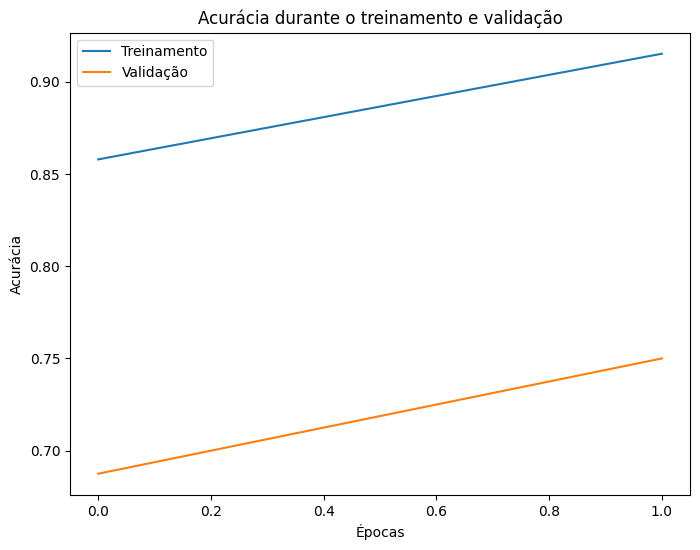

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 362ms/step

Relatório de Classificação:
              precision    recall  f1-score   support

      NORMAL       0.97      0.66      0.79       234
   PNEUMONIA       0.83      0.99      0.90       390

    accuracy                           0.87       624
   macro avg       0.90      0.82      0.84       624
weighted avg       0.88      0.87      0.86       624



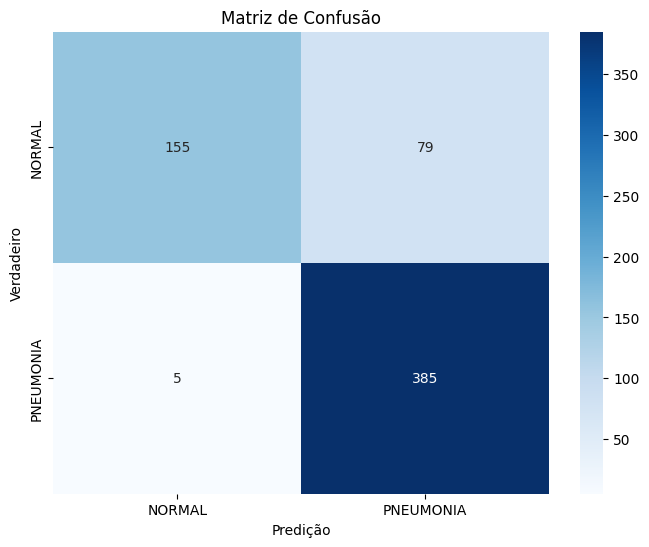

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


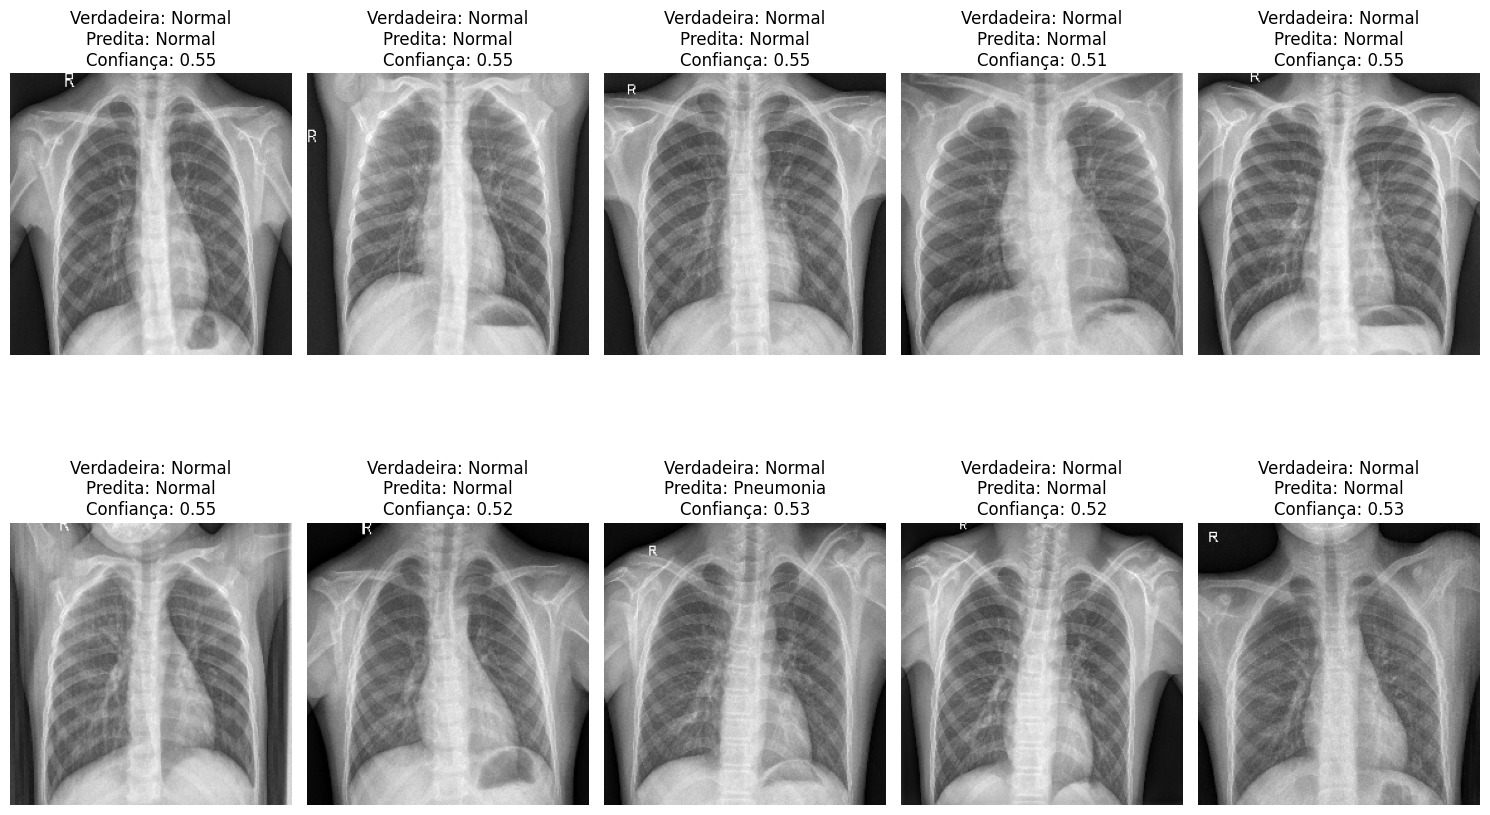

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

train = '/content/drive/MyDrive/RV/Projeto/train'
val = '/content/drive/MyDrive/RV/Projeto/val'
test = '/content/drive/MyDrive/RV/Projeto/test'

datagen_treino = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_val_teste = ImageDataGenerator(rescale=1.0/255)

treino_generator = datagen_treino.flow_from_directory(
    train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = datagen_val_teste.flow_from_directory(
    val,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

teste_generator = datagen_val_teste.flow_from_directory(
    test,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

modelo = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduzir_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

historia = modelo.fit(
    treino_generator,
    epochs=2,
    validation_data=val_generator,
    callbacks=[early_stopping, reduzir_lr]
)

teste_loss, teste_acc = modelo.evaluate(teste_generator)
print(f"Perda no conjunto de teste: {teste_loss:.4f}")
print(f"Acurácia no conjunto de teste: {teste_acc * 100:.2f}%")

plt.figure(figsize=(8, 6))
plt.plot(historia.history['accuracy'], label='Treinamento')
plt.plot(historia.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.title('Acurácia durante o treinamento e validação')
plt.legend()
plt.show()

y_pred = modelo.predict(teste_generator) > 0.5
y_true = teste_generator.classes

print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=teste_generator.class_indices.keys()))

conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=teste_generator.class_indices.keys(), yticklabels=teste_generator.class_indices.keys())
plt.xlabel("Predição")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()

imagens, labels = next(teste_generator)
predicoes = modelo.predict(imagens)

plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imagens[i])
    predicao = predicoes[i][0]
    classe_predita = 'Pneumonia' if predicao > 0.5 else 'Normal'
    confianca = predicao if predicao > 0.5 else 1 - predicao

    if classe_predita == 'Pneumonia':
        arquivo_imagem = teste_generator.filenames[i]
        if 'bacteria' in arquivo_imagem.lower():
            classe_predita += ' (Bactéria)'
        elif 'virus' in arquivo_imagem.lower():
            classe_predita += ' (Vírus)'

    classe_verdadeira = 'Pneumonia' if labels[i] == 1 else 'Normal'
    plt.title(f'Verdadeira: {classe_verdadeira}\nPredita: {classe_predita}\nConfiança: {confianca:.2f}')
    plt.axis('off')

plt.tight_layout()
plt.show()
